# Setup Environment
Creo una sessione con Sagemaker in modo da poterlo utilizzare e definisco alcune variabili di lavoro

In [69]:
import os
import subprocess
import boto3
import sagemaker

from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()
s3_bucket_name=sagemaker_session.default_bucket()

prefix="AnalisiChurn"

### Uso Athena per mettere a punto le query di estrazione
Athena è un servizio di query serverless. Il modello di costo è i base ai TB di dati scansionati per produrre generare la risposta.
Le feature principali sono:
* Immediatamente disponibile: Legge le informazioni sui dati (struttura e dove trovarli nel datalake) direttamente dal Catalogo
* nessuna query = Costo 0
* Consente di fare data mashup: Può leggere e correlare informazioni provenienti da sorgenti diverse: Datalake, Database Relazionali, DWH (Redshift)

E' uno strumento adatto per analizzare i dati presenti all'interno di una azienda

Installo le librerie per poter scaricare i dati da Athena e finire la preparazione del dataset

In [2]:
import sys
!{sys.executable} -m pip install PyAthena

     |████████████████████████████████| 53 kB 2.3 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Mi collego all'istanza di Athena della region dove ho creato il datalake

In [3]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://fede-analytics-694275606777/athena_queries_sagemaker',
               region_name='eu-west-1')

In [30]:
df_churn = pd.read_sql("""
select *
from datalake.customer_view_churn_analisys a ,datalake.jconsensi_json b 
where
a.key_soggetti=b.index and
b.consenso='Y' limit 10000
""", conn)

In [33]:
df_churn.head()

,key_soggetti,nazione_nascita,rating_creditizio,retention_value,comune_residenza,cognome,eta_cliente,vas,canale_contatto_preferenziale,titolo_di_studio,...,sardegna,sicilia,toscana,trentino_alto_adige,umbria,valle_d_aosta,veneto,index,consenso,timestamp
0,107093.0,Italia,C,None,Molfetta,Carosi,52.0,None,None,Laurea magistrale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107093,Y,1499048803977
1,107093.0,Italia,C,None,Molfetta,Carosi,52.0,None,None,Laurea magistrale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107093,Y,1483219486878
2,107093.0,Italia,C,None,Molfetta,Carosi,52.0,None,None,Laurea magistrale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107093,Y,1553732703853
3,1341473.0,Italia,C,SILVER,Brescia,Mazzucco,54.0,None,Telefono,Dottorato,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1341473,Y,1492187243172
4,1341473.0,Italia,C,SILVER,Brescia,Mazzucco,54.0,None,Telefono,Dottorato,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1341473,Y,1535647781701


## Uso Redshift per le query di estrazione

In [86]:
!pip install psycopg2-binary

     |████████████████████████████████| 3.0 MB 9.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [91]:
import psycopg2
rscon=psycopg2.connect(
    dbname   = 'dev', 
    host     = '172.31.0.220', 
    port     = '5439', 
    user     = 'awsuser', 
    password = 'F3d3r1c0!'
)

In [92]:
df_churn = pd.read_sql("""
select *
from local_customer_view_churn_analisys a ,datalake.jconsensi_json b 
where
a.key_soggetti=b.index and
b.consenso='Y' limit 10000
""", rscon)

In [93]:
df_churn.head()

,key_soggetti,nazione_nascita,rating_creditizio,retention_value,comune_residenza,cognome,eta_cliente,vas,canale_contatto_preferenziale,titolo_di_studio,...,sardegna,sicilia,toscana,trentino_alto_adige,umbria,valle_d_aosta,veneto,index,consenso,timestamp
0,1604775.0,Italia,B,None,Arezzo,Angelotti,46.0,None,None,Laurea breve,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1604775,Y,1600326434645
1,1088307.0,Italia,B,None,Campobasso,Speranza,46.0,None,None,Dottorato,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1088307,Y,1496441608767
2,1088307.0,Italia,B,None,Campobasso,Speranza,46.0,None,None,Dottorato,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1088307,Y,1496441608767
3,1647075.0,Italia,B,None,Ragusa,Spano,28.0,None,Email,Dottorato,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1647075,Y,1608780909624
4,1647075.0,Italia,B,None,Ragusa,Spano,28.0,None,Email,Dottorato,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1647075,Y,1608780909624


In [36]:
df_churn=df_churn.drop (columns=['key_soggetti','rank','index','timestamp'])

In [45]:
regioni=df_churn['regione'].unique()
regioni

array(['Puglia', 'Piemonte', 'Sardegna', 'Calabria', 'Veneto', 'Lazio',
       'Umbria', 'Toscana', 'Lombardia', 'Emilia romagna', 'Campania',
       'Friuli venezia giulia', 'Sicilia', 'Liguria', 'Valle d aosta',
       'Basilicata', 'Trentino alto adige', 'Molise', 'Abruzzo', 'Marche'],
      dtype=object)

In [49]:
def get_regione (x):
    if x>0:
        return 1
    return 0
    
for regione in regioni:
    regione=regione.lower().replace(' ','_')
    df_churn[regione+"_lbl"]=df_churn[regione].apply(lambda x: get_regione(x))

In [55]:
def get_churn (x):
    if x>0:
        return 1
    return 0
df_churn["churn_tgt"]=df_churn["churn"].apply(lambda x: get_churn(x))

In [56]:
for regione in regioni:
    regione=regione.lower().replace(' ','_')
    df_churn=df_churn.drop(columns=[regione])

In [58]:
df_churn=df_churn.drop(columns=['churn'])

In [60]:
df_churn=df_churn.drop(columns=['regione'])

In [77]:
train_data=df_churn.sample(frac=0.8,random_state=200)
test_data = df_churn.drop(train_data.index)

## Primo Esperimento
Uso Auopilot, una nuova funzionalità di Sagemaker, che ha in se la parte di ingegnerizzazione delle features e usa XGBoost come algoritmo.


Duplico il dataset per arrivare fino a 1000 elementi (minimo per usare Autopilot), aumentando il numero di casi positivi rispetto al totale.
Il training set è molto sbilanciato.

In [63]:
train_data.count()

nazione_nascita                     10000
rating_creditizio                   10000
retention_value                      1261
comune_residenza                    10000
cognome                             10000
eta_cliente                         10000
vas                                  1073
canale_contatto_preferenziale        3755
titolo_di_studio                    10000
tipologia_cliente                   10000
data_iscrizione_sportello_online     2018
nome                                10000
count                               10000
debito_medio                        10000
data_attivazione_fornitura          10000
media_gas                            5543
media_ele                            7797
canale_di_vendita                   10000
consenso                            10000
puglia_lbl                          10000
piemonte_lbl                        10000
sardegna_lbl                        10000
calabria_lbl                        10000
veneto_lbl                        

## Use Sagemaker Autopilot to train the model

After uploading the dataset to Amazon S3, you can invoke Autopilot to find the best ML pipeline to train a model on this dataset.

The required inputs for invoking a Autopilot job are:

* Amazon S3 location for input dataset and for all output artifacts
* Name of the column of the dataset you want to predict (esito_inattesp_tampone_successivo in this case)
* An IAM role 

Currently Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order by name, is expected to have a header row.

In [64]:
train_file = 'train_data.csv';
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = sagemaker_session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)


Train data uploaded to: s3://sagemaker-eu-west-1-694275606777/AnalisiChurn/train/train_data.csv


In [65]:
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(s3_bucket_name,prefix)
        }
      },
      'TargetAttributeName': 'churn_tgt'
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(s3_bucket_name,prefix)
  }


You can also specify the type of problem you want to solve with your dataset (Regression, MulticlassClassification, BinaryClassification). In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict).

Because the target attribute, Churn?, is binary, our model will be performing binary prediction, also known as binary classification. In this example we will let AutoPilot infer the type of problem for us.

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a Candidate because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job takes about four hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

## Launching the SageMaker Autopilot Job
You can now launch the Autopilot job by calling the create_auto_ml_job API. We limit the number of candidates to 20 so that the job finishes in a few minutes.



In [72]:
import boto3 

from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

sm = boto3.Session().client(service_name='sagemaker',region_name='eu-west-1')

auto_ml_job_name = 'automl-churn-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig={'CompletionCriteria':
                                       {'MaxCandidates': 20}
                                      },
                      RoleArn=role)

AutoMLJobName: automl-churn-23-16-47-57


{'AutoMLJobArn': 'arn:aws:sagemaker:eu-west-1:694275606777:automl-job/automl-churn-23-16-47-57',
 'ResponseMetadata': {'RequestId': 'ce47bcb5-7eb3-4985-ad48-98cbbf2dbe49',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ce47bcb5-7eb3-4985-ad48-98cbbf2dbe49',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '95',
   'date': 'Fri, 23 Oct 2020 16:47:58 GMT'},
  'RetryAttempts': 0}}


## Tracking SageMaker Autopilot job progress¶
SageMaker Autopilot job consists of the following high-level steps :

* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline).

In [73]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineer

## Results
Now use the describe_auto_ml_job API to look up the best candidate selected by the SageMaker Autopilot job.


In [74]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

{'CandidateName': 'tuning-job-1-595d6096e1be43a2a2-015-94373110', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:f1', 'Value': 0.9852499961853027}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:694275606777:processing-job/db-1-82c14c75e1644eecbbf4ee60fbf2c79d1e5a8361273e428781e5a84ecd', 'CandidateStepName': 'db-1-82c14c75e1644eecbbf4ee60fbf2c79d1e5a8361273e428781e5a84ecd'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:694275606777:training-job/automl-chu-dpp7-1-fac214d5915a4bf687b26a7906cb33227ff74a4a9a7d4', 'CandidateStepName': 'automl-chu-dpp7-1-fac214d5915a4bf687b26a7906cb33227ff74a4a9a7d4'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:694275606777:transform-job/automl-chu-dpp7-rpb-1-8677bb68fcd4471288753520a45cd9129b5ba92b8', 'CandidateStepName': '

## Host
Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [75]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
model_name = best_candidate_name + timestamp_suffix + "-model"
model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

epc_name = best_candidate_name + timestamp_suffix + "-epc"
ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType': 'ml.m5.xlarge',
                                                           'InitialInstanceCount': 1,
                                                           'ModelName': model_name,
                                                           'VariantName': 'main'}])

ep_name = best_candidate_name + timestamp_suffix + "-ep"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name,
                                              EndpointConfigName=epc_name)

In [76]:
sm.get_waiter('endpoint_in_service').wait(EndpointName=ep_name)


## Evaluate
Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request. But first, we'll need to setup serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.

In [79]:

from io import StringIO
from sagemaker.predictor import RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV


predictor = RealTimePredictor(
    endpoint=ep_name,
    sagemaker_session=sagemaker_session,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_CSV)

# Remove the target column from the test data
test_data_inference = test_data.drop(columns=['churn_tgt'])

# Obtain predictions from SageMaker endpoint
prediction = predictor.predict(test_data_inference.to_csv(sep=',', header=False, index=False)).decode('utf-8')

# Load prediction in pandas and compare to ground truth
prediction_df = pd.read_csv(StringIO(prediction), header=None)
accuracy = (test_data.reset_index()['churn_tgt'] == prediction_df[0]).sum() / len(test_data_inference)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.994


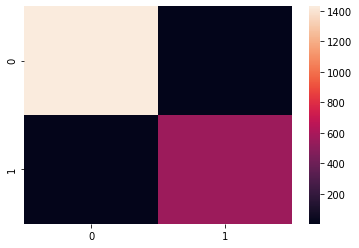

[[1430    3]
 [   9  558]]


In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
from  sklearn.metrics import confusion_matrix

cm=confusion_matrix( test_data.churn_tgt, prediction_df[0])
sn.heatmap(cm)
plt.show()
print (cm)

In [82]:
# Remove the target column from the test data
test_data_inference = train_data.drop(columns=['churn_tgt'])

# Obtain predictions from SageMaker endpoint
prediction = predictor.predict(test_data_inference.to_csv(sep=',', header=False, index=False)).decode('utf-8')

# Load prediction in pandas and compare to ground truth
prediction_df = pd.read_csv(StringIO(prediction), header=None)
accuracy = (train_data.reset_index()['churn_tgt'] == prediction_df[0]).sum() / len(test_data_inference)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.995125


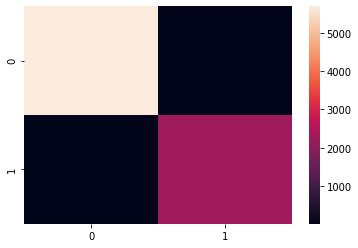

[[5690   15]
 [  24 2271]]


In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
from  sklearn.metrics import confusion_matrix

cm=confusion_matrix( train_data.churn_tgt, prediction_df[0])
sn.heatmap(cm)
plt.show()
print (cm)

## Cleanup
The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them. This operation deletes all the generated models and the auto-generated notebooks as well.

In [ ]:
#s3 = boto3.resource('s3')
#s3_bucket = s3.Bucket(bucket)

#job_outputs_prefix = '{}/output/{}'.format(prefix, auto_ml_job_name)
#s3_bucket.objects.filter(Prefix=job_outputs_prefix).delete()

In [85]:
sm.delete_endpoint(EndpointName=ep_name)
sm.delete_endpoint_config(EndpointConfigName=epc_name)
sm.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': 'd03b69dd-862f-4166-92a9-44bcb7717cce',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd03b69dd-862f-4166-92a9-44bcb7717cce',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 23 Oct 2020 17:22:05 GMT'},
  'RetryAttempts': 0}}